<a href="https://colab.research.google.com/github/RichardCYC/Bike_sharing_demand_prediction/blob/Delete_wrong_file/Bike_share_prediction_v5_%E7%9B%B4%E6%8E%A5%E9%A0%90%E6%B8%ACcount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview

**Bike sharing demand prediction**

Project Objective：
Predict bike sharing demand by hour

[Kaggle link](https://www.kaggle.com/c/bike-sharing-demand/overview)



---

**Data Fields**
*   datetime - hourly date + timestamp  
*   season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
*   holiday - whether the day is considered a holiday
*   workingday - whether the day is neither a weekend nor holiday
*   weather - 
    *   1: Clear, Few clouds, Partly cloudy, Partly cloudy
    *   2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    *   3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    *   4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
*   temp - temperature in Celsius
*   atemp - "feels like" temperature in Celsius
*   humidity - relative humidity
*   windspeed - wind speed
*   casual - number of non-registered user rentals initiated
*   registered - number of registered user rentals initiated
*   count - number of total rentals

In [69]:
# mount google drive to get data
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/Colab_Notebooks') 
os.getcwd() 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/MyDrive/Colab_Notebooks'

In [70]:
# import module
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # ignore warnings

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [71]:
# read data(combine training & testing data)
train = pd.read_csv('Bike_share_prediction/train.csv') 
test = pd.read_csv('Bike_share_prediction/test.csv') 
combine = pd.concat([train, test])

# EDA

In [72]:
# check data 
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.7+ MB


**Finding**

* No missing values
* There are no casual, registered and count values in testing dataset

In [73]:
combine.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,10886.000000,10886.000000
mean,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,36.021955,155.552177,191.574132
std,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,17.000000,118.000000,145.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000


**Finding**

* There are outliers, whose values are abnormally high, in "casual", "registered" and "count". We can drop those data to do better prediction later.

In [74]:
# drop data whose values are abnormally high(more than mean+3x std)
train = train[(train['casual'] < train['casual'].mean()+3* train['casual'].std())\
                  &(train['registered'] < train['registered'].mean()+3* train['registered'].std())\
                  &(train['count'] < train['count'].mean()+3* train['count'].std())]

combine = pd.concat([train, test])

In [75]:
combine.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


**Finding**

* We have hourly date + timestamp in "datetime" and we can extract more information such as year and month from "datetime" later.

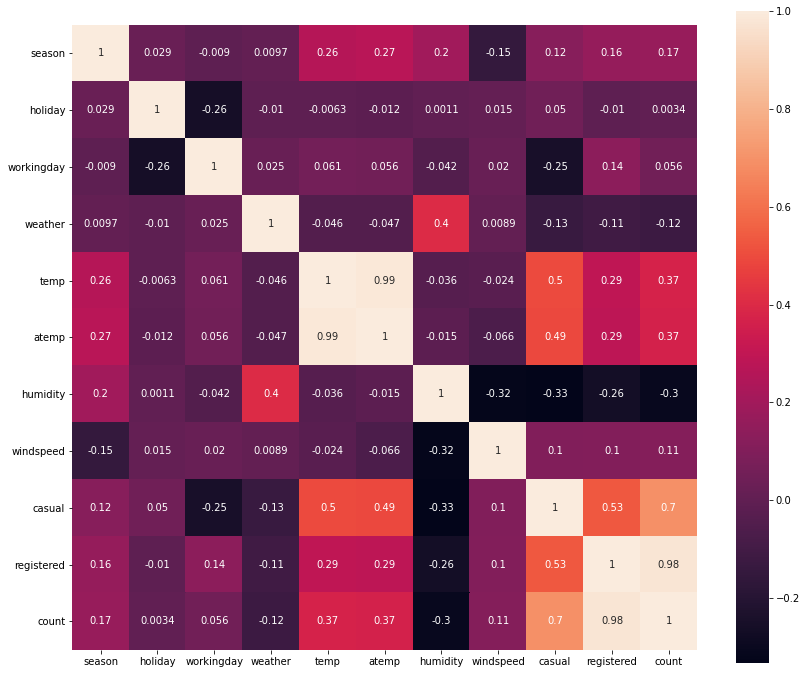

In [76]:
# use heatmap to see the correlations among features
plt.figure(figsize=(14,12))
sns.heatmap(train.corr(), square=True, annot=True)

**Finding**

* "atemp", "temp" and "humidity" have relatively strong correlation with "count".
* The correlation between "temp" and "atemp" is pretty strong so that we only use one of them as feature if needed.

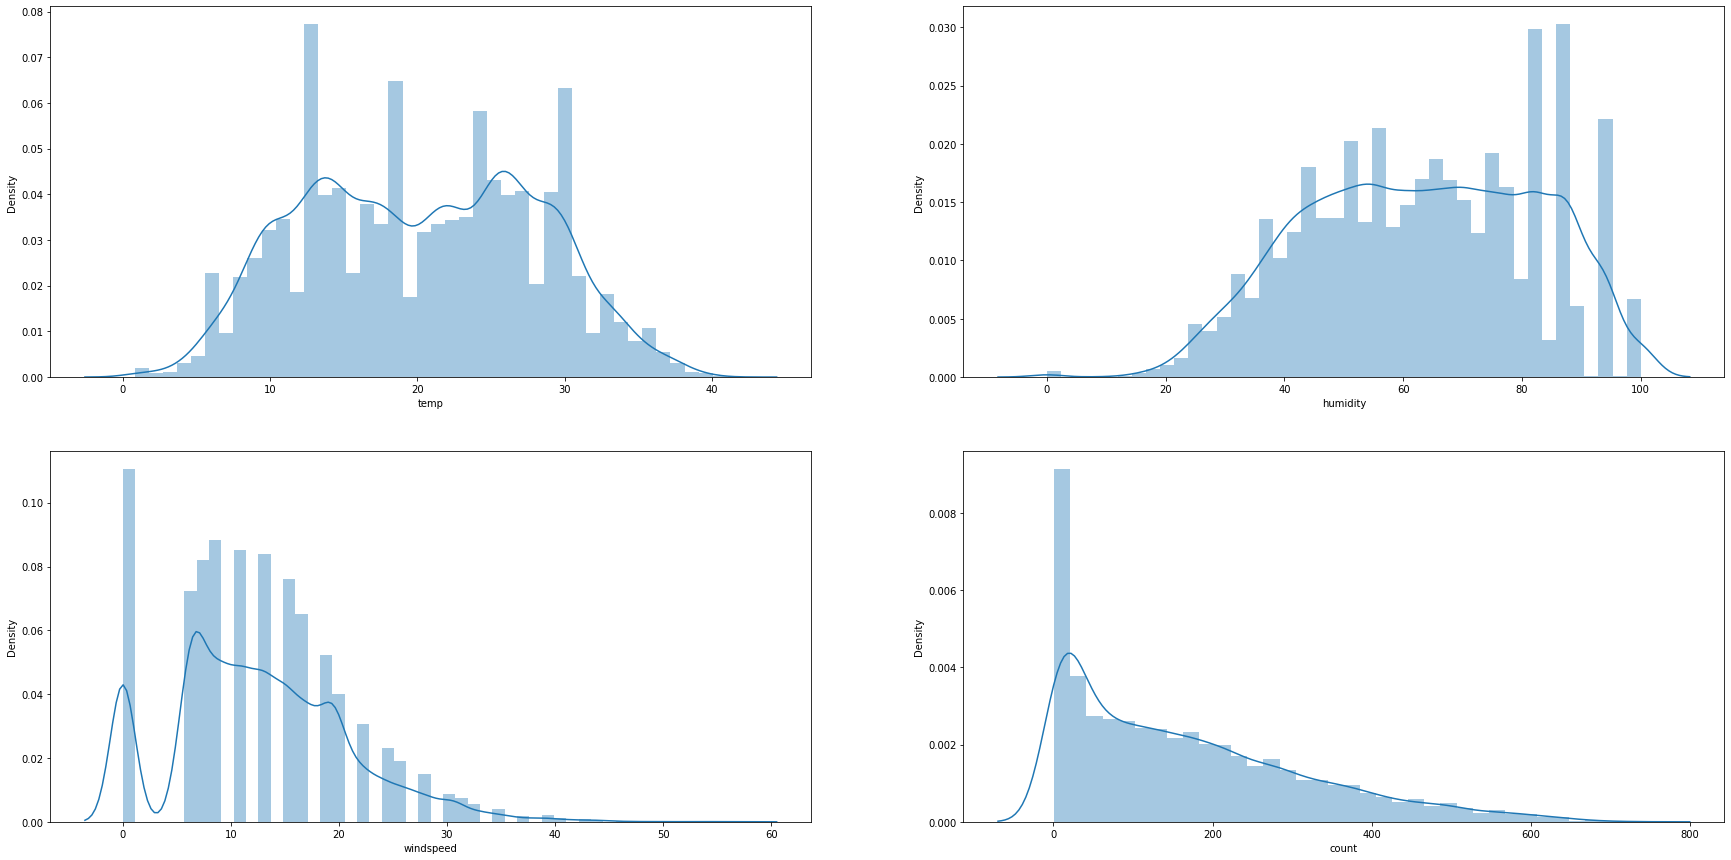

In [77]:
# see the distribution of columns whose data type is numeral
numeral = ['temp', 'humidity', 'windspeed', 'count']
fig, axes = plt.subplots(2,2,figsize=(30, 15))
count = 0
for i in range(2):
  for j in range(2):
    x = numeral[count]
    sns.distplot(combine[x], ax=axes[i,j])
    count += 1

**Finding**

* Our target("count") is skewed. We can take the log of it to do a better prediction.
* "0" holds a big share in "windspeed" but there is no data between 0-7, which is adnormal. Maybe the data wasn't collected correctly. We can use a model to calculate new values of "windspeed" for those data whose "windspeed" are "0".

In [78]:
# take the log of "count", which we will use later
combine['log_count'] = combine['count'].map(lambda x:np.log(x))

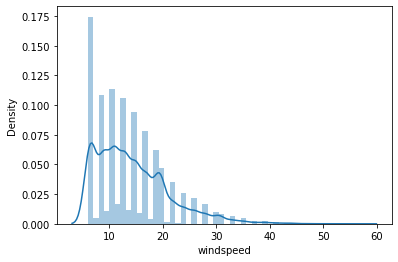

In [79]:
# calculate new value of "windspeed" for those data whose "windspeed" are 0 before seeing the distribution of target by windspeed
clf_rf = RandomForestRegressor(
    n_estimators=500, \
    max_depth=None, \
    min_samples_split=10)

windspeed0 = combine[combine['windspeed'] == 0]
windspeednot0 = combine[combine['windspeed'] != 0]

wind_related_column = ['season', 'weather', 'temp', 'humidity']

windspeednot0_x = windspeednot0[wind_related_column]
windspeednot0_y = windspeednot0['windspeed']

model_rf = clf_rf.fit(windspeednot0_x, windspeednot0_y)
windspeed0['windspeed'] = model_rf.predict(windspeed0[wind_related_column])

combine = windspeednot0.append(windspeed0)
sns.distplot(combine['windspeed'])

**Finding**

* After replacing "0" with values predicted, the distribution of windspeed is more like normal distribution.

In [80]:
# extract time-related information from "datetime"
combine['year'] = combine['datetime'].apply(lambda x:x[0:4])
combine['month'] = combine['datetime'].apply(lambda x:x[5:7])
combine['date'] = combine['datetime'].apply(lambda x:x[8:10])
combine['hour'] = combine['datetime'].apply(lambda x:x[11:13])

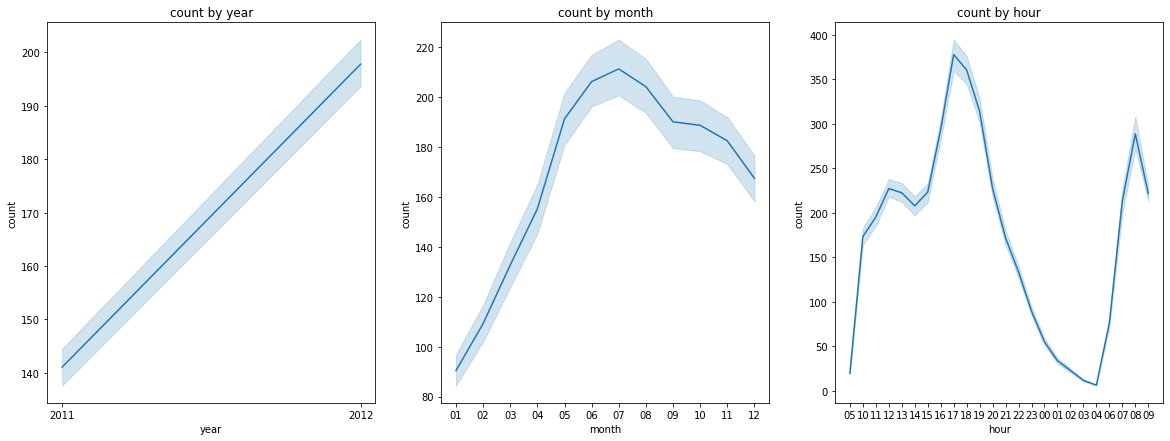

In [81]:
# see the distribution of count by year, month and hour(time-related columns)
target = ['year', 'month', 'hour']
fig, axes = plt.subplots(1,3,figsize=(20, 7))

for tar, i in zip(target, range(3)):
  sns.lineplot(x = combine[tar], y=combine['count'], ax=axes[i])
  axes[i].set_title('count by '+tar)

**Finding**

* The differences of "count" are obvious within these three features.

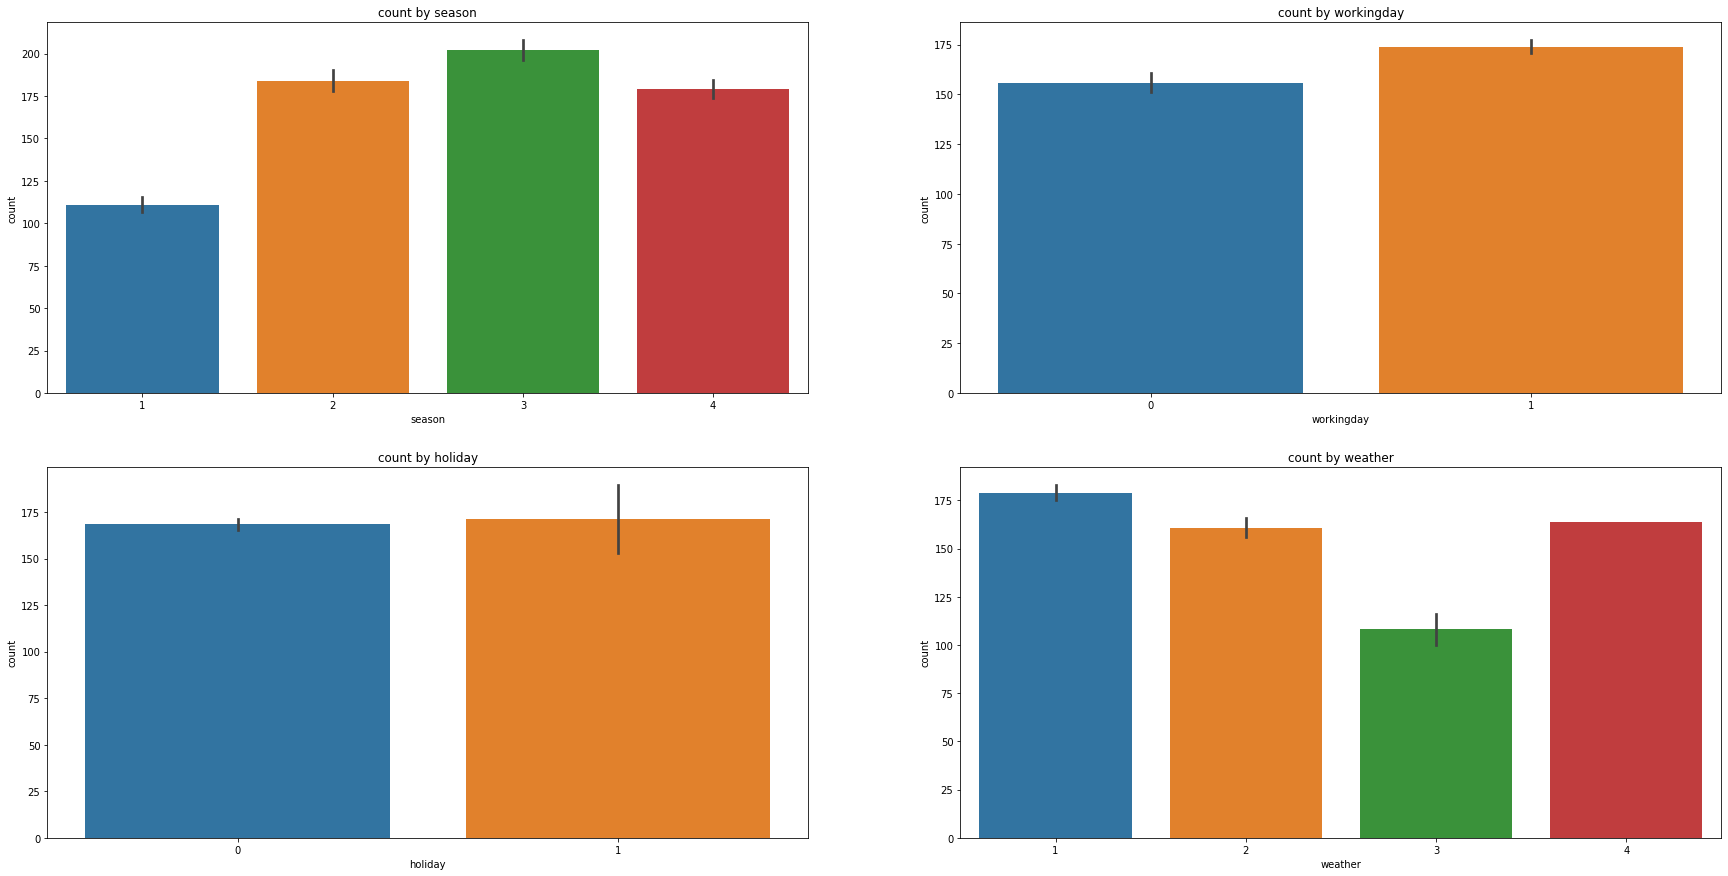

In [82]:
# see the distribution of count by season, workingday, holiday and weather(categorical data)
target = ['season', 'workingday', 'holiday', 'weather']
fig, axes = plt.subplots(2,2,figsize=(30, 15))
count = 0
for i in range(2):
  for j in range(2):
    x = target[count]
    sns.barplot(x = combine[x], y=combine['count'], ax=axes[i,j])
    axes[i,j].set_title('count by '+x)
    count += 1

**Finding**

* The differences of "count" are obvious within "season", "workingday" and "weather" but not obvious within "holiday".

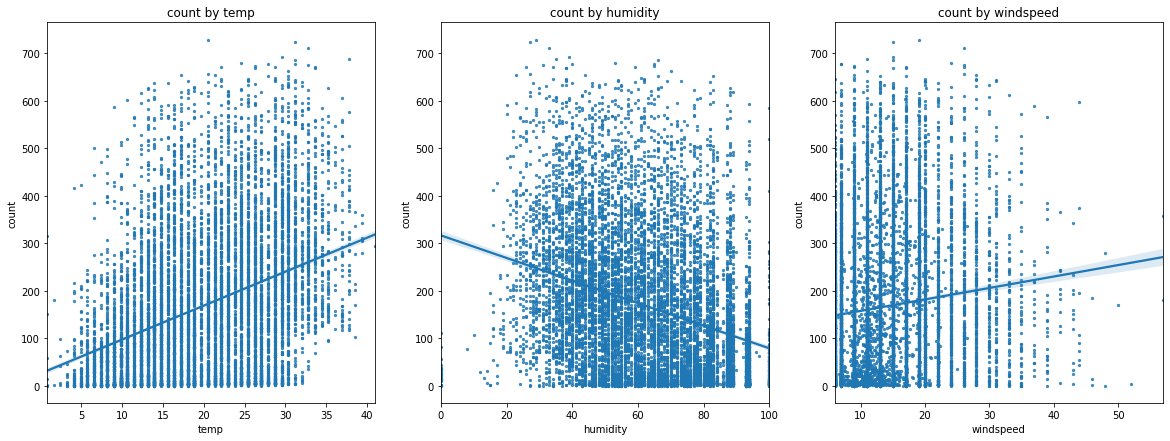

In [83]:
# see the distribution of count by temp, humidity and windspeed(numeral data)
target = ['temp', 'humidity', 'windspeed']
fig, axes = plt.subplots(1,3,figsize=(20, 7))

for tar, i in zip(target, range(3)):
  sns.regplot(x = combine[tar], y=combine['count'], ax=axes[i], scatter_kws={'s':5})
  axes[i].set_title('count by '+tar)

**Finding**

* The correlation (between "count" and "temp") and (between "count" and "humidity") is stronger than the correlation (between "count" and "windspeed").

# Modeling

In [84]:
# check what columns we have
combine.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'log_count', 'year', 'month', 'date', 'hour'],
      dtype='object')

In [88]:
# set columns which we don't use
drop_columns = ['datetime', 'date', 'holiday', 'casual', 'registered', 'count', 'log_count']

In [89]:
# split training data into training and val(validation)
training = combine[combine['date'].astype('int')<16]
val = combine[(combine['date'].astype('int')>15) & (combine['date'].astype('int')<20)]

In [90]:
# process training data for modeling

x_training = training.drop(columns = drop_columns)
y_training = training['log_count']

In [91]:
# setting up parameters for RandomForest
clf_rf = RandomForestRegressor(
    n_estimators=1000, \
    max_depth=None, \
    min_samples_split=10)

In [92]:
# fit model for "casual"
model = clf_rf.fit(x_training, y_training)

In [99]:
# use validation data to see how model performs
x_val = val.drop(columns = drop_columns)
y_val = val['count']
validation = np.exp(model.predict(x_val))

MSLE = mean_squared_log_error(validation, y_val)
RMSLE = MSLE ** 0.5
print('MSLE = ', MSLE)
print('RMSLE = ', RMSLE)

MSLE =  0.13235105747215786
RMSLE =  0.3638008486413382


In [100]:
# use all training data to fit model
all_train = combine[combine['count'].notnull()]
x_all_train = all_train.drop(columns = drop_columns)
y_all_train = all_train['log_count']

model = clf_rf.fit(x_all_train, y_all_train)

In [102]:
# output predictions to csv
test = combine[combine['date'].astype('int')>19]
prediction = np.exp(model.predict(test.drop(columns=drop_columns)))
submission = test['datetime'].to_frame()
submission['count'] = [max(0,x) for x in prediction]
submission.to_csv('Bike_share_prediction/answer_count_v5.csv', index = False)